In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import humanize

# Data For Good - Tax Observatory Dataviz

Visualizations for the EU Tax Observatory based on the [EU Tax Obs - Dataviz - Viz](https://docs.google.com/document/d/1q_7x8NrEWNsak9LSE3TxIiSphhVcqWqn6YeG1kQNQTk/edit#heading=h.97g77izer615) Google Docs.

## Table of contents
* [Initialization](#initialization)
* [#12 - available reports by company](#12---available-reports-by-company)
* [#13 - company key financials kpis](#13---company-key-financials-kpis)
* [#14 - company top jurisdictions for revenue](#14---company-top-jurisdictions-for-revenue)
* [#15 - company’s % pre-tax profit and % employees by jurisdiction](#15---companys--pre-tax-profit-and--employees-by-jurisdiction)
* [#18 - breakdown of revenue between related party and unrelated party in TH vs domestic vs non TH](#18---breakdown-of-revenue-between-related-party-and-unrelated-party-in-th-vs-domestic-vs-non-th)

## Initialization

In [2]:
# Import dataset in a DataFrame
df = pd.read_csv('data_final_dataviz.csv', sep=',')

In the website it will be possible to select a specific company. To work on the viz creation, we simulate the selection by picking a random company but also a random year.

In [3]:
# Select a random company and a random year
def pick_random_company_and_year() -> tuple:
    company = np.random.choice(df['mnc'].unique())
    print(f'Selected company : {company}.')

    year = np.random.choice(df.loc[df['mnc'] == company, 'year'].unique())
    print(f'Selected year : {year}.')

    return company, year

In [4]:
company, year = pick_random_company_and_year()
# company, year = 'SHELL', 2020

Selected company : LUSH.
Selected year : 2019.


## #12 - available reports by company

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|tbd (goal is on company page, to show reports tracked, so could be just a table showing year available for a company)|-||`company explo` need a filter by company||

In [29]:
def compute_company_available_reports(df: pd.DataFrame, company: str) -> dict:
    """Compute the number of reports tracked for a specific company and the 
    available fiscal years.

    Args:
        df (pd.DataFrame): CbCRs database.
        company (str): company name.

    Returns:
        dict: numbers of reports and fiscal years.
    """
    available_years = df.loc[df['mnc'] == company, 'year'].unique()
    n_reports = len(available_years)

    # Convert type of items from 'int' to 'str' in available years list
    years_string_list = [str(year) for year in available_years]
    
    # Summarize all available years in one string
    if len(years_string_list) == 1:
        years_string = years_string_list[0]
    elif len(years_string_list) > 1:
        years_string = ', '.join(years_string_list[:-1])
        years_string += ' and ' + years_string_list[-1]

    # Create a dictionnary with the results
    data = {
        'Company': company,
        'Reports': n_reports,
        'Fiscal year(s) available': years_string
    }

    return data


def display_company_available_reports(
        df: pd.DataFrame, company: str, hide_company: bool=True) -> pd.DataFrame:
    """Display the number of reports tracked for a specific company and the 
    available fiscal years.

    Args:
        df (pd.DataFrame): CbCRs database.
        company (str): company name.
        hide_company (bool, optional): hide company name in final table. Defaults to True.

    Returns:
        pd.DataFrame: numbers of reports and fiscal years.
    """
    
    # Compute data
    data = compute_company_available_reports(df=df, company=company)

    # Create the table
    df = pd.DataFrame.from_dict(data=data, orient='index')

    if hide_company:
        return df[1:].style.hide(axis='columns')

    return df.style.hide(axis='columns')

In [30]:
display_company_available_reports(df=df, company=company, hide_company=True)

Reports,3
Fiscal year(s) available,"2019, 2020 and 2021"


## #13 - company key financials kpis

**kpis** : hq country, total revenue, total unrelated party revenues, total related party revenues, pre-tax profits, taxes paid, employees.

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|raw figure for each, or table with indicator name in col A, value in col B|hq country : -<br><br>metrics : sum (metric) by year by mnc|**giulia : keep all values, even negative values**|`company explo` need a filter by company||

In [58]:
def compute_company_key_financials_kpis(
        df: pd.DataFrame, company: str, year: int=None) -> dict:
    """Compute key financial KPIs for a company.

    Args:
        df (pd.DataFrame): CbCRs database.
        company (str): Company name
        year (int, optional): fiscal year to filter the results with. Defaults to None.

    Returns:
        dict: company key financial KPIs.
    """
    
    kpis_list = ['total_revenues', 'unrelated_revenues', 'related_revenues', 
                 'profit_before_tax', 'tax_paid', 'employees']
    
    years_list = df.loc[df['mnc'] == company, 'year'].unique()

    # Compute sum of kpis
    if not year or year not in years_list:
        df = (df.loc[df['mnc'] == company]
            .groupby(['year', 'upe_name'], as_index=False)[kpis_list]
            .sum()
        )
    else:
        df = (df.loc[(df['mnc'] == company) & (df['year'] == year)]
              .groupby(['year', 'upe_name'], as_index=False)[kpis_list]
              .sum())

    df = df.set_index('year')

    # Make financial numbers easily readable with 'humanize' package
    for column in df.columns:
        if column not in ['employees', 'upe_name']:
            df[column] = df[column].apply(
                lambda x: humanize.intword(x) if isinstance(x, (int, float)) else x)
            df[column] = '€ ' + df[column]
        elif column == 'employees':
            df[column] = df[column].astype(int)

    # Clean columns string
    df = df.rename(columns={'upe_name': 'headquarter'})
    df.columns = df.columns.str.replace('_', ' ').str.capitalize()

    # Create a dictionnary with the results
    data = df.to_dict(orient='index')

    return data


def display_company_key_financials_kpis(
        df: pd.DataFrame, company: str, year: int=None) -> pd.DataFrame:
    """Display key financial KPIs for a company.

    Args:
        df (pd.DataFrame): CbCRs database.
        company (str): Company name
        year (int, optional): fiscal year to filter the results with. Defaults to None.

    Returns:
        pd.DataFrame: company key financial KPIs.
    """
    
    # Compute data
    data = compute_company_key_financials_kpis(df=df, company=company, year=year)

    # Create the table
    df = pd.DataFrame.from_dict(data)

    return df

In [61]:
display_company_key_financials_kpis(df=df, company=company)

,2019,2020,2021
Headquarter,United Kingdom,United Kingdom,United Kingdom
Total revenues,€ 792.1 million,€ 622.7 million,€ 612.8 million
Unrelated revenues,€ 547.9 million,€ 445.8 million,€ 413.2 million
Related revenues,€ 244.2 million,€ 176.8 million,€ 199.5 million
Profit before tax,€ -13.0 million,€ -126.2 million,€ -1.6 million
Tax paid,€ 8.2 million,€ 4.4 million,€ 6.6 million
Employees,12548,11687,8638


## #14 - company top jurisdictions for revenue

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|horizontal bar chart showing % total revenue for top 9 jurisdictions + rest as “OTHERS”|sum(revenue) by company x hq country x year, display top 9 and group remaining countries||`company explo` need a filter by company||

In [68]:
def compute_top_jurisdictions_revenue(
        df: pd.DataFrame=df, company: str=company, year:int=year) -> dict:
    
    df = df.loc[(df['mnc'] == company) & (df['year'] == year), ['jur_name', 'total_revenues']]
    df = df.fillna(0)
    df = df.sort_values(by='total_revenues', ascending=False)

    top = df[:9].copy()

    others = df[9:]['total_revenues'].sum()
    top.loc[9] = ['Others', others]

    top['total_revenues_%'] = top['total_revenues'] / top['total_revenues'].sum() * 100

    top = top.sort_values(by='total_revenues_%').reset_index(drop=True)

    data = top.to_dict()
    
    return data

In [69]:
pd.DataFrame(compute_top_jurisdictions_revenue())

,jur_name,total_revenues,total_revenues_%
0,Portugal,1.519500e+08,1.199847
1,Chile,2.255300e+08,1.780859
2,Slovakia,2.408700e+08,1.901989
3,Canada,2.698600e+08,2.130904
4,Others,3.051700e+08,2.409723
5,Australia,8.883400e+08,7.014626
6,Poland,1.808190e+09,14.278066
7,United States of America,2.736420e+09,21.607677
8,United Kingdom,3.006250e+09,23.738344
9,Spain,3.031530e+09,23.937963


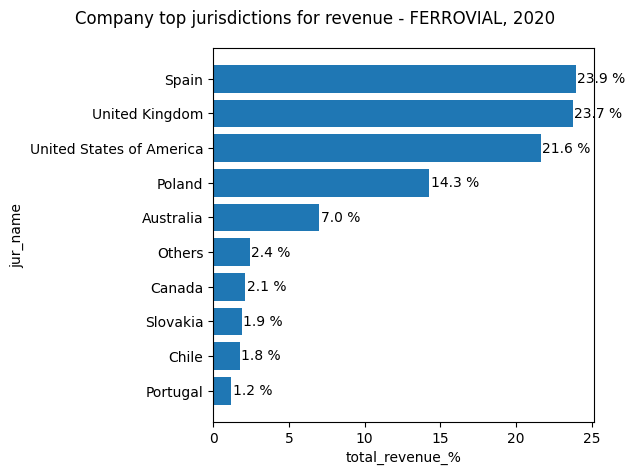

In [70]:
def plot_jurisdictions_top_revenue():

    top = pd.DataFrame(compute_top_jurisdictions_revenue())

    fig, ax = plt.subplots()
    bar = ax.barh(y=top['jur_name'], width=top['total_revenues_%'])

    ax.bar_label(bar, fmt='{:.1f} %', padding=1)

    ax.tick_params(axis='x', rotation=0)
    ax.set_xlabel('total_revenue_%')
    ax.set_ylabel('jur_name')

    fig.suptitle(f'Company top jurisdictions for revenue - {company}, {year}')

    plt.tight_layout()
    plt.show()

plot_jurisdictions_top_revenue()

## #15 - company’s % pre-tax profit and % employees by jurisdiction

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|horizontal bar chart with one bar for % pre tax profit, the other for % employees, in different colors rank by % pre-tax profit descending|for a company : filter (profit >0) profits by JUR / total profit vs employees by JUR / total employees|**giulia : keep only positive values**|`company explo` need a filter by company||

In [71]:
def compute_pretax_profit_and_employees_rank(
        df: pd.DataFrame=df, company: str=company, year: int=year) -> dict:
    
    df = df.loc[
        (df['mnc'] == company) & (df['year'] == year) & (df['profit_before_tax'] > 0), 
        ['jur_name', 'profit_before_tax', 'employees']
    ]

    df = df.fillna(0)
    df = df.sort_values(by='profit_before_tax').reset_index(drop=True)

    df['profit_before_tax_%'] = df['profit_before_tax'] / df['profit_before_tax'].sum() * 100
    df['employees_%'] = df['employees'] / df['employees'].sum() * 100

    data = df.to_dict()

    return data

In [72]:
pd.DataFrame(compute_pretax_profit_and_employees_rank())

,jur_name,profit_before_tax,employees,profit_before_tax_%,employees_%
0,New Zealand,10000.0,0.0,0.002477,0.000000
1,United Arab Emirates,20000.0,0.0,0.004954,0.000000
2,Italy,210000.0,2.0,0.052012,0.003999
3,Brazil,310000.0,1.0,0.076780,0.001999
4,Oman,410000.0,14.0,0.101548,0.027991
5,Puerto Rico,1110000.0,194.0,0.274923,0.387876
6,Luxembourg,1860000.0,0.0,0.460681,0.000000
7,Germany,5420000.0,872.0,1.342415,1.743442
8,Chile,6330000.0,4524.0,1.567802,9.045106
9,Ireland,6700000.0,3.0,1.659443,0.005998


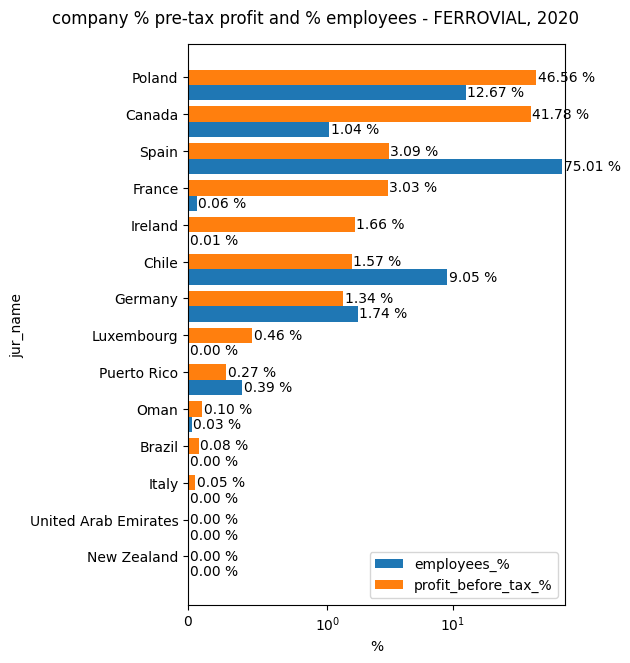

In [73]:
def plot_pretax_profit_and_employees_rank():

    rank = pd.DataFrame(compute_pretax_profit_and_employees_rank())

    jurisdictions = rank['jur_name'].values
    bar_width = 0.42
    bar_offsets = [-bar_width, 0, bar_width]

    fig_height = max(4.8, (0.48*len(jurisdictions)))
    fig, ax = plt.subplots(figsize=(6.4, fig_height))

    for i, (column, values) in enumerate(rank[['employees_%', 'profit_before_tax_%']].items()):
        bar_positions = []
        for j in range(len(jurisdictions)):
            bar_positions.append(j + bar_offsets[i])
        bars = ax.barh(bar_positions, values, height=bar_width, label=column)
        ax.bar_label(bars, fmt='{:.2f} %', padding=1)

    ax.set_xlabel('%')
    ax.set_yticks(range(len(jurisdictions)))
    ax.set_yticklabels(jurisdictions)
    ax.set_ylabel('jur_name')
    ax.set_xscale('symlog', linthresh=1)
    ax.legend(loc='lower right')
       
    fig.suptitle(f'company % pre-tax profit and % employees - {company}, {year}')

    plt.tight_layout()
    plt.show()

plot_pretax_profit_and_employees_rank()

## #18 - breakdown of revenue between related party and unrelated party in TH vs domestic vs non TH

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|horizontal barchart % of revenue from related-party revenue, and % revenue from unrelated party, show value for domestic (hq country) vs tax havens vs. non havens|get total revenue in TH, in domestic country, in non TH then show the % coming from unrelated party revenue and related party revenue (sum of both should equal total revenue)||`company explo` need a filter by company|what if sum or unrelated party revenue  and related party revenue does not equal to total revenue ? safeguard ?|

In [74]:
def compute_related_and_unrelated_revenues_breakdown(
        df: pd.DataFrame=df, company: str=company, year: int=year) -> dict:
    
    # Create a filtered version of the dataset
    df_temp = df.loc[(df['mnc'] == company) & (df['year'] == year)].copy()

    # Create a boolean column to check if 'jur_code' is the domestic country
    df_temp['domestic'] = df_temp.apply(
        lambda row: row['jur_code'] == row['upe_code'], axis='columns')

    # Calculate missing values in 'related_revenues' if 'unrelated_revenues' and 'total_revenues' are available
    df_temp.loc[
        df_temp['unrelated_revenues'].notna() 
        & df_temp['total_revenues'].notna() 
        & df_temp['related_revenues'].isna(), 
        'related_revenues'
    ] = df_temp['total_revenues'] - df_temp['unrelated_revenues']

    # Calculate missing values in 'unrelated_revenues' if 'related_revenues' and 'total_revenues' are available
    df_temp.loc[
        df_temp['related_revenues'].notna() 
        & df_temp['total_revenues'].notna() 
        & df_temp['unrelated_revenues'].isna(), 
        'unrelated_revenues'
    ] = df_temp['total_revenues'] - df_temp['related_revenues']

    # Remove columns where 'unrelated_revenues' or 'related_revenues' is missing
    df_temp = df_temp.dropna(subset=['unrelated_revenues', 'related_revenues'])

    # Compute kpis in a new DataFrame
    data = pd.DataFrame()
    data['th_revenues'] = df_temp.loc[
        df_temp['jur_tax_haven'] == True, ['unrelated_revenues', 'related_revenues']].sum()
    data['non_th_revenues'] = df_temp.loc[
        df_temp['jur_tax_haven'] == False, ['unrelated_revenues', 'related_revenues']].sum()
    data['domestic_revenues'] = df_temp.loc[
        df_temp['domestic'] == True, ['unrelated_revenues', 'related_revenues']].sum()

    # Replace values with share (%) of 'unrelated/related revenues'
    data = data.div(data.sum(axis='rows'), axis='columns') * 100

    # Convert DataFrame to dictionnary
    data = data.to_dict()

    return data

compute_related_and_unrelated_revenues_breakdown()

{'th_revenues': {'unrelated_revenues': 79.58236658932715,
  'related_revenues': 20.417633410672853},
 'non_th_revenues': {'unrelated_revenues': 98.04026747356541,
  'related_revenues': 1.9597325264345826},
 'domestic_revenues': {'unrelated_revenues': 92.84255804824626,
  'related_revenues': 7.157441951753735}}

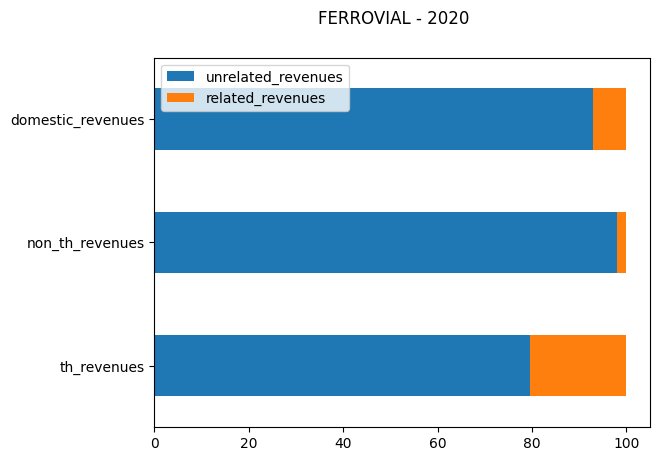

In [75]:
fig, ax = plt.subplots()

test = pd.DataFrame(compute_related_and_unrelated_revenues_breakdown()).T

test.plot(kind='barh', stacked=True, ax=ax)

fig.suptitle(f'{company} - {year}')
plt.show()